# Ant Maze With Branch and Bound

In [1]:

import numpy as np
from collections import deque
from PIL import Image, ImageDraw, ImageFont
import os
import time
time_list=[]
obstacles1 = [(0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(8,2),
    (8,3),(8,4),(8,5),(8,6),(8,7),(8,8),(7,8),(6,8),(5,8),(4,8),(3,8),(2,8),
    (1,8),(1,7),(1,6),(1,5),(1,4),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(6,4),
   (6,5),(6,6),(5,6),(4,6),(3,6),(3,5),(4,5)]
goal1=[5,5]
goal2=[2,6]
goal3=[9,9]
goal4=[3,8]
obstacles2= [(3,0),(5,0),(8,0),(1,1),(2,1),(3,1),(5,1),(6,1),(3,2),(8,2),(0,3),(1,3),
            (3,3),(5,3),(6,3),(8,3),(9,3),(1,4),(5,4),(6,4),(1,5),(2,5),(3,5),(4,5),
            (5,5),(6,5),(7,5),(7,6),(8,5),(3,6),(1,7),(2,7),(3,7),(5,7),(6,7),(7,7),(9,7),
            (9,8),(1,9),(2,9),(3,9),(4,9),(5,9),(6,9),(7,9),(9,9)]
obstacles3=[(0,1),(2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),
            (6,0),(6,1),(6,2),(6,3),(6,4),(6,5),(6,6),(6,7),(6,8),
            (4,1),(4,2),(4,3),(4,4),(4,5),(4,6),(4,7),(4,8),(4,9),
            (8,1),(8,2),(8,3),(8,4),(8,5),(8,6),(8,7),(8,8),(8,9)
            ]
obstacles4=[(0,1),(1,1),(3,0),(3,1),(6,0),(6,1),(6,2),(6,3),(8,0),(8,1),(8,2),(8,3),
           (8,4),(8,5),(0,3),(1,3),(2,3),(3,3),(4,3),(1,5),(2,5),(3,5),(4,5),(5,5),
            (6,5),(6,6),(6,7),(0,7),(1,7),(2,7),(3,7),(6,9)]
obstacles=[obstacles1,obstacles2,obstacles3,obstacles4]
goal=[goal1,goal2,goal3,goal4]
for i in range(4):
  ts=time.time()
  class frozen_lake:
      def __init__(self, m, n, location=[0, 0], goal=[-1, -1], obstacles=None):
          self.a = np.char.array(np.zeros((m, n), dtype=int).astype(str))
          self.location = location
          self.a[self.location[0], self.location[1]] = "+"
          self.n = n
          self.m = m
          self.goal = goal


          if obstacles:
              for obs in obstacles:
                  self.a[obs[0], obs[1]] = "X"

          self.a[self.goal[0], self.goal[1]] = "G"

          if not os.path.exists("frames"):
              os.makedirs("frames")

      def move_left(self):
          if self.location[1] > 0:
              self.location[1] -= 1
              self.agent()
          else:
              print("can't go left further")

      def move_right(self):
          if self.location[1] < self.n - 1:
              self.location[1] += 1
              self.agent()
          else:
              print("can't go right further")

      def move_up(self):
          if self.location[0] > 0:
              self.location[0] -= 1
              self.agent()
          else:
              print("can't go up further")

      def move_down(self):
          if self.location[0] < self.m - 1:
              self.location[0] += 1
              self.agent()
          else:
              print("can't go down further")

      def agent(self):
          self.reset()
          self.a[self.location[0], self.location[1]] = "+"

      def show(self, frame_number):

          cell_size = 50
          width = self.n * cell_size
          height = self.m * cell_size
          img = Image.new('RGB', (width, height), color='white')
          draw = ImageDraw.Draw(img)


          colors = {
              "0": (255, 255, 255),
              "X": (255, 0, 0),
              "+": (0, 255, 0),
              "G": (0, 0, 255)
          }

          for i in range(self.m):
              for j in range(self.n):
                  color = colors[self.a[i, j]]
                  x0 = j * cell_size
                  y0 = i * cell_size
                  x1 = x0 + cell_size
                  y1 = y0 + cell_size
                  draw.rectangle([x0, y0, x1, y1], fill=color)

          for i in range(self.m + 1):

              draw.line((0, i * cell_size, width, i * cell_size), fill=(0, 0, 0), width=2)
          for j in range(self.n + 1):

              draw.line((j * cell_size, 0, j * cell_size, height), fill=(0, 0, 0), width=2)


          agent_x = self.location[1] * cell_size + cell_size // 2
          agent_y = self.location[0] * cell_size + cell_size // 2
          agent_radius = cell_size // 4
          draw.ellipse([agent_x - agent_radius, agent_y - agent_radius, agent_x + agent_radius, agent_y + agent_radius], fill=(0, 255, 0))


          img.save(f"frames/frame_{frame_number}.png")

      def reset(self):
          for i in range(self.m):
              for j in range(self.n):
                  if self.a[i, j] != "X" and self.a[i, j] != "G":
                      self.a[i, j] = "0"

  class node(frozen_lake):
      def __init__(self, m, n, x_crnt, y_crnt, x_goal, y_goal, obstacles=None):
          super().__init__(m, n, location=[x_crnt, y_crnt], goal=[x_goal, y_goal], obstacles=obstacles)
          self.x_crnt = x_crnt
          self.y_crnt = y_crnt
          self.x_goal = x_goal
          self.y_goal = y_goal
          self.m = m
          self.n = n
          self.directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

      def manhattan_distance(self, x_crnt, y_crnt):
          return abs(x_crnt - self.x_goal) + abs(y_crnt - self.y_goal)

      def branch_and_bound(self):


          queue = deque([(0 + self.manhattan_distance(self.x_crnt, self.y_crnt), 0, self.x_crnt, self.y_crnt, [])])
          visited = set()

          best_cost = float('inf')
          best_path = []

          while queue:
              cost, g, x, y, path = queue.popleft()

              if (x, y) == (self.x_goal, self.y_goal):
                  if cost < best_cost:
                      best_cost = cost
                      best_path = path + [(x, y)]
                  continue

              if (x, y) in visited:
                  continue

              visited.add((x, y))


              for dx, dy in self.directions:
                  nx, ny = x + dx, y + dy
                  if 0 <= nx < self.m and 0 <= ny < self.n and (nx, ny) not in visited:

                      if self.a[nx, ny] == "X":
                          continue

                      new_g = g + 1
                      new_cost = new_g + self.manhattan_distance(nx, ny)
                      queue.append((new_cost, new_g, nx, ny, path + [(x, y)]))

          return best_path

      def follow_path(self, path):
          frame_number = 0
          for (x, y) in path:
              self.location = [x, y]
              self.agent()
              self.show(frame_number)
              frame_number += 1

          self.create_gif()

      def create_gif(self):

          image_files = [f"frames/frame_{i}.png" for i in range(len(os.listdir('frames')))]
          images = [Image.open(img) for img in image_files]


          images[0].save(f"frozen_lake_BnB{i}.gif", save_all=True, append_images=images[1:], duration=500, loop=0)
          for img in image_files:
              os.remove(img)

          print("GIF created")




  x = node(10, 10, 0, 0,goal[i][0],goal[i][1], obstacles=obstacles[i])
  path = x.branch_and_bound()
  if path:
      print("Path found:", path)
      x.follow_path(path)
  else:
      print("No path found.")
  te=time.time()
  time_list.append(te-ts)
print(time_list)
average_time=sum(time_list)/len(time_list)
print("average time= ",sum(time_list)/len(time_list))

Path found: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (6, 7), (5, 7), (4, 7), (3, 7), (2, 7), (2, 6), (2, 5), (2, 4), (3, 4), (4, 4), (5, 4), (5, 5)]
GIF created
Path found: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 3), (4, 2), (5, 2), (6, 2), (7, 2), (7, 3), (7, 4), (8, 4), (9, 4), (9, 5), (9, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (2, 8), (1, 8), (0, 8), (0, 7), (0, 6), (1, 6), (2, 6)]
GIF created
Path found: [(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 9), (3, 9), (3, 8), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (4, 0), (

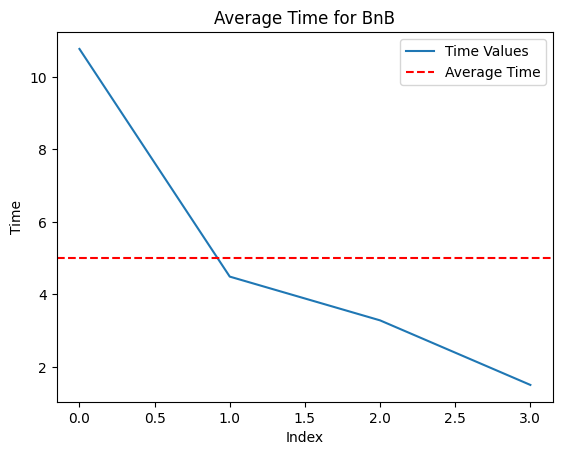

In [ ]:
import matplotlib.pyplot as plt
plt.plot(time_list, label='Time Values')
plt.axhline(average_time, color='r', linestyle='--', label='Average Time')
plt.title('Average Time for BnB')
plt.xlabel('Index')
plt.ylabel('Time')
plt.legend()
plt.show()

# Ant Maze With Iterative Deepening A*

In [9]:

import numpy as np
from collections import deque
from PIL import Image, ImageDraw, ImageFont
import os
time_list=[]
obstacles1 = [(0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(8,2),
    (8,3),(8,4),(8,5),(8,6),(8,7),(8,8),(7,8),(6,8),(5,8),(4,8),(3,8),(2,8),
    (1,8),(1,7),(1,6),(1,5),(1,4),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(6,4),
   (6,5),(6,6),(5,6),(4,6),(3,6),(3,5),(4,5)]
goal1=[5,5]
goal2=[2,6]
goal3=[9,9]
goal4=[3,8]
obstacles2= [(3,0),(5,0),(8,0),(1,1),(2,1),(3,1),(5,1),(6,1),(3,2),(8,2),(0,3),(1,3),
            (3,3),(5,3),(6,3),(8,3),(9,3),(1,4),(5,4),(6,4),(1,5),(2,5),(3,5),(4,5),
            (5,5),(6,5),(7,5),(7,6),(8,5),(3,6),(1,7),(2,7),(3,7),(5,7),(6,7),(7,7),(9,7),
            (9,8),(1,9),(2,9),(3,9),(4,9),(5,9),(6,9),(7,9),(9,9)]
obstacles3=[(0,1),(2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),
            (6,0),(6,1),(6,2),(6,3),(6,4),(6,5),(6,6),(6,7),(6,8),
            (4,1),(4,2),(4,3),(4,4),(4,5),(4,6),(4,7),(4,8),(4,9),
            (8,1),(8,2),(8,3),(8,4),(8,5),(8,6),(8,7),(8,8),(8,9)
            ]
obstacles4=[(0,1),(1,1),(3,0),(3,1),(6,0),(6,1),(6,2),(6,3),(8,0),(8,1),(8,2),(8,3),
(8,4),(8,5),(0,3),(1,3),(2,3),(3,3),(4,3),(1,5),(2,5),(3,5),(4,5),(5,5),
(6,5),(6,6),(6,7),(0,7),(1,7),(2,7),(3,7),(6,9)]
obstacles=[obstacles1,obstacles2,obstacles3,obstacles4]
goal=[goal1,goal2,goal3,goal4]
for i in range(4):
  ts=time.time()
  class frozen_lake:
      def __init__(self, m, n, location=[0, 0], goal=[-1, -1], obstacles=None):
          self.a = np.char.array(np.zeros((m, n), dtype=int).astype(str))
          self.location = location
          self.a[self.location[0], self.location[1]] = "+"
          self.n = n
          self.m = m
          self.goal = goal


          if obstacles:
              for obs in obstacles:
                  self.a[obs[0], obs[1]] = "X"


          self.a[self.goal[0], self.goal[1]] = "G"


          if not os.path.exists("frames"):
              os.makedirs("frames")

      def move_left(self):
          if self.location[1] > 0:
              self.location[1] -= 1
              self.agent()
          else:
              print("can't go left further")

      def move_right(self):
          if self.location[1] < self.n - 1:
              self.location[1] += 1
              self.agent()
          else:
              print("can't go right further")

      def move_up(self):
          if self.location[0] > 0:
              self.location[0] -= 1
              self.agent()
          else:
              print("can't go up further")

      def move_down(self):
          if self.location[0] < self.m - 1:
              self.location[0] += 1
              self.agent()
          else:
              print("can't go down further")

      def agent(self):
          self.reset()
          self.a[self.location[0], self.location[1]] = "+"

      def show(self, frame_number):

          cell_size = 50
          width = self.n * cell_size
          height = self.m * cell_size
          img = Image.new('RGB', (width, height), color='white')
          draw = ImageDraw.Draw(img)


          colors = {
              "0": (255, 255, 255),
              "X": (255, 0, 0),
              "+": (0, 255, 0),
              "G": (0, 0, 255)
          }


          for i in range(self.m):
              for j in range(self.n):
                  color = colors[self.a[i, j]]
                  x0 = j * cell_size
                  y0 = i * cell_size
                  x1 = x0 + cell_size
                  y1 = y0 + cell_size
                  draw.rectangle([x0, y0, x1, y1], fill=color)


          for i in range(self.m + 1):

              draw.line((0, i * cell_size, width, i * cell_size), fill=(0, 0, 0), width=2)
          for j in range(self.n + 1):

              draw.line((j * cell_size, 0, j * cell_size, height), fill=(0, 0, 0), width=2)


          agent_x = self.location[1] * cell_size + cell_size // 2
          agent_y = self.location[0] * cell_size + cell_size // 2
          agent_radius = cell_size // 4
          draw.ellipse([agent_x - agent_radius, agent_y - agent_radius, agent_x + agent_radius, agent_y + agent_radius], fill=(0, 255, 0))


          img.save(f"frames/frame_{frame_number}.png")

      def reset(self):
          for i in range(self.m):
              for j in range(self.n):
                  if self.a[i, j] != "X" and self.a[i, j] != "G":
                      self.a[i, j] = "0"

  class node(frozen_lake):
      def __init__(self, m, n, x_crnt, y_crnt, x_goal, y_goal, obstacles=None):
          super().__init__(m, n, location=[x_crnt, y_crnt], goal=[x_goal, y_goal], obstacles=obstacles)
          self.x_crnt = x_crnt
          self.y_crnt = y_crnt
          self.x_goal = x_goal
          self.y_goal = y_goal
          self.m = m
          self.n = n
          self.directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

      def manhattan_distance(self, x_crnt, y_crnt):
          return abs(x_crnt - self.x_goal) + abs(y_crnt - self.y_goal)

      def ida_star(self):

          bound = self.manhattan_distance(self.x_crnt, self.y_crnt)
          path = [(self.x_crnt, self.y_crnt)]
          while True:
              t = self.ida_star_search(path, 0, bound)
              if t == 'found':
                  return path
              elif t == float('inf'):
                  return None
              bound = t

      def ida_star_search(self, path, g, bound):

          x, y = path[-1]
          f = g + self.manhattan_distance(x, y)


          if f > bound:
              return f


          if (x, y) == (self.x_goal, self.y_goal):
              return 'found'

          min_cost = float('inf')
          for dx, dy in self.directions:
              nx, ny = x + dx, y + dy
              if 0 <= nx < self.m and 0 <= ny < self.n and self.a[nx, ny] != "X" and (nx, ny) not in path:
                  path.append((nx, ny))
                  t = self.ida_star_search(path, g + 1, bound)
                  if t == 'found':
                      return 'found'
                  if t < min_cost:
                      min_cost = t
                  path.pop()

          return min_cost

      def follow_path(self, path):
          frame_number = 0
          for (x, y) in path:
              self.location = [x, y]
              self.agent()
              self.show(frame_number)
              frame_number += 1


          self.create_gif()

      def create_gif(self):

          image_files = [f"frames/frame_{i}.png" for i in range(len(os.listdir('frames')))]
          images = [Image.open(img) for img in image_files]

          images[0].save(f"frozen_lake_IDA*{i}.gif", save_all=True, append_images=images[1:], duration=500, loop=0)
          for img in image_files:
              os.remove(img)

          print("GIF created")



  # obstacles = [(0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(8,2),(8,3),(8,4),(8,5),(8,6),(8,7),(8,8),(7,8),(6,8),(5,8),(4,8),(3,8),(2,8),(1,8),(1,7),(1,6),(1,5),(1,4),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(6,4),(6,5),(6,6),(5,6),(4,6),(3,6),(3,5),(4,5)]  # Example of obstacles
  x = node(10, 10, 0, 0,goal[i][0],goal[i][1], obstacles=obstacles[i])
  path = x.ida_star()
  if path:
      print("Path found:", path)
      x.follow_path(path)
  else:
      print("No path found.")
  te=time.time()
  time_list.append(te-ts)
print(time_list)
print("average time= ",sum(time_list)/len(time_list))


Path found: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (6, 7), (5, 7), (4, 7), (3, 7), (2, 7), (2, 6), (2, 5), (2, 4), (3, 4), (4, 4), (5, 4), (5, 5)]
GIF created
Path found: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 3), (4, 2), (5, 2), (6, 2), (7, 2), (7, 3), (7, 4), (8, 4), (9, 4), (9, 5), (9, 6), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (2, 8), (1, 8), (0, 8), (0, 7), (0, 6), (1, 6), (2, 6)]
GIF created
Path found: [(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 9), (3, 9), (3, 8), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (4, 0), (

In [2]:
time_for_ida=time_list
average_time1=sum(time_for_ida)/len(time_for_ida)

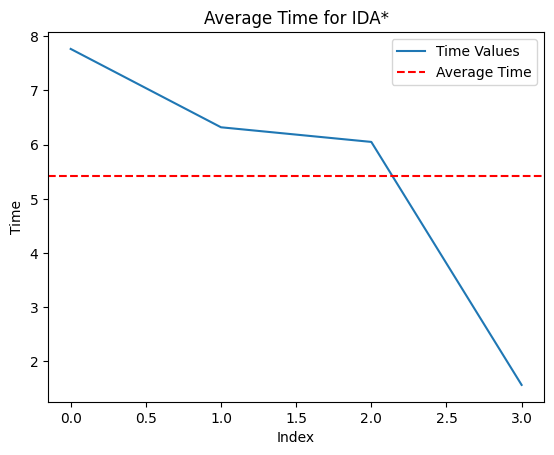

In [6]:
import matplotlib.pyplot as plt
plt.plot(time_for_ida, label='Time Values')

plt.axhline(average_time1, color='r', linestyle='--', label='Average Time')
plt.title('Average Time for IDA*')
plt.xlabel('Index')
plt.ylabel('Time')
plt.legend()
plt.show()

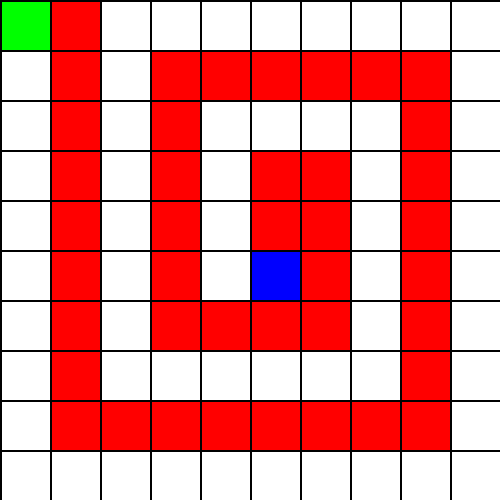

In [8]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_BnB0.gif'))

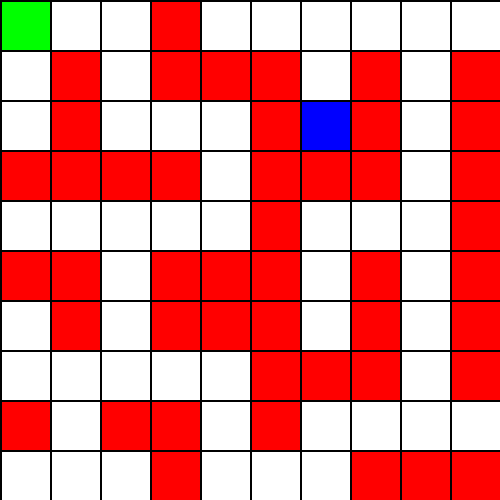

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_BnB1.gif'))

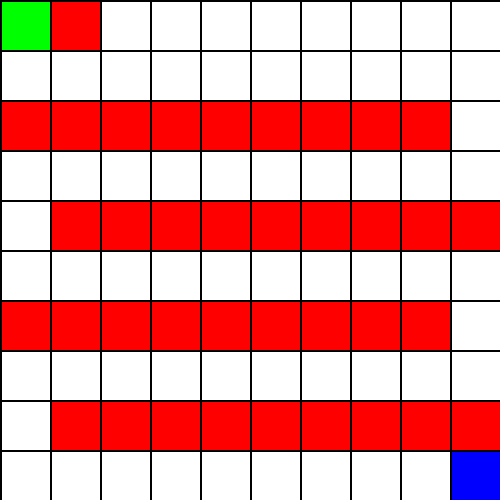

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_BnB2.gif'))

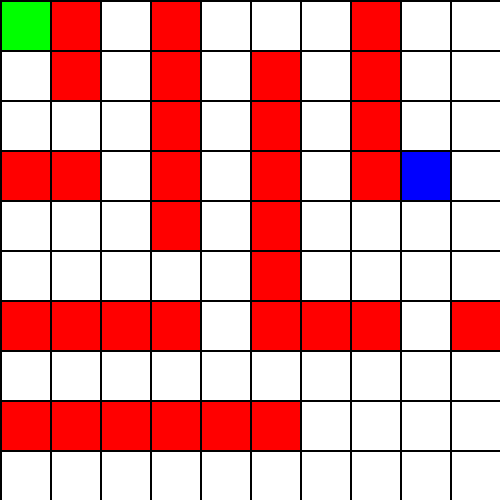

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_BnB3.gif'))

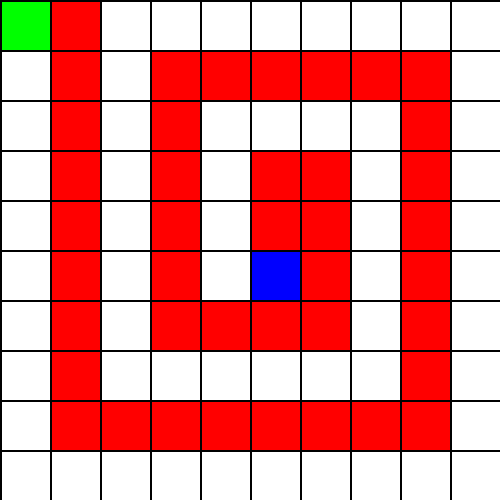

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_IDA*0.gif'))

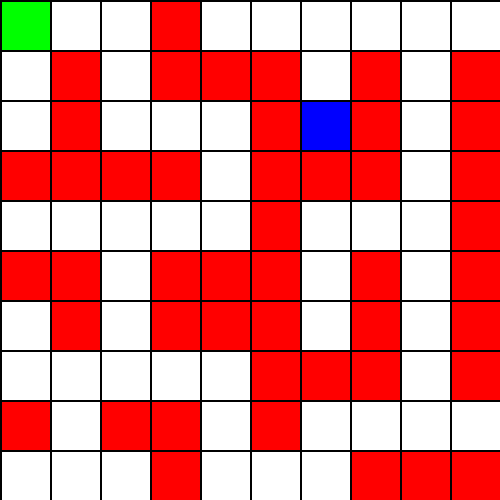

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_IDA*1.gif'))

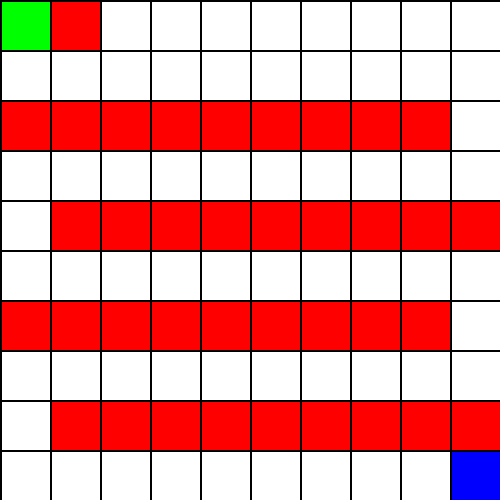

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_IDA*2.gif'))

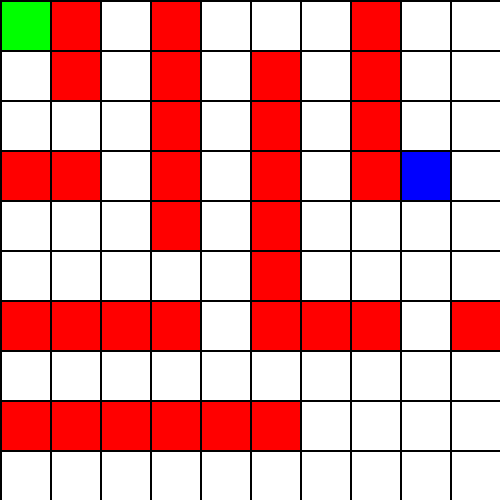

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/frozen_lake_IDA*3.gif'))